In [1]:
%pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [2]:
"""
# End-to-End Machine Learning Project: HR Employee Attrition Prediction

This notebook walks through a complete machine learning project, from data exploration to model deployment. We will be using the IBM HR Analytics Attrition dataset.

**Project Steps:**
1.  **Setup & Data Loading:** Import libraries and load the dataset.
2.  **Basic Data Analysis:** Initial exploration of the dataset's structure and statistics.
3.  **Data Cleaning:** Handle missing values and identify/address outliers.
4.  **Exploratory Data Analysis (EDA):** Deep dive into the data with visualizations to uncover insights.
5.  **Data Preprocessing:** Prepare the data for machine learning models.
6.  **Hyperparameter Tuning with Optuna:** Find the best performing algorithms and their optimal hyperparameters.
7.  **Model Training & Evaluation:** Train and evaluate the top 3 models identified by Optuna.
8.  **Save Final Model:** Serialize the best model for future use.
"""

# ## 1. Setup & Data Loading
# Import all the necessary libraries for the project.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import optuna
import pickle

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
)

In [4]:
# Import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [5]:
# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [8]:
# Load the dataset
# The file 'WA_Fn-UseC_-HR-Employee-Attrition.csv' should be in the same directory
# or you should provide the full path to the file.
try:
    df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: 'WA_Fn-UseC_-HR-Employee-Attrition.csv' not found.")
    print("Please make sure the dataset file is in the correct directory.")
    # As a fallback for demonstration, create a dummy dataframe
    df = pd.DataFrame()

Dataset loaded successfully!



--- Basic Data Analysis ---

[INFO] First 5 rows of the dataset:
   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  

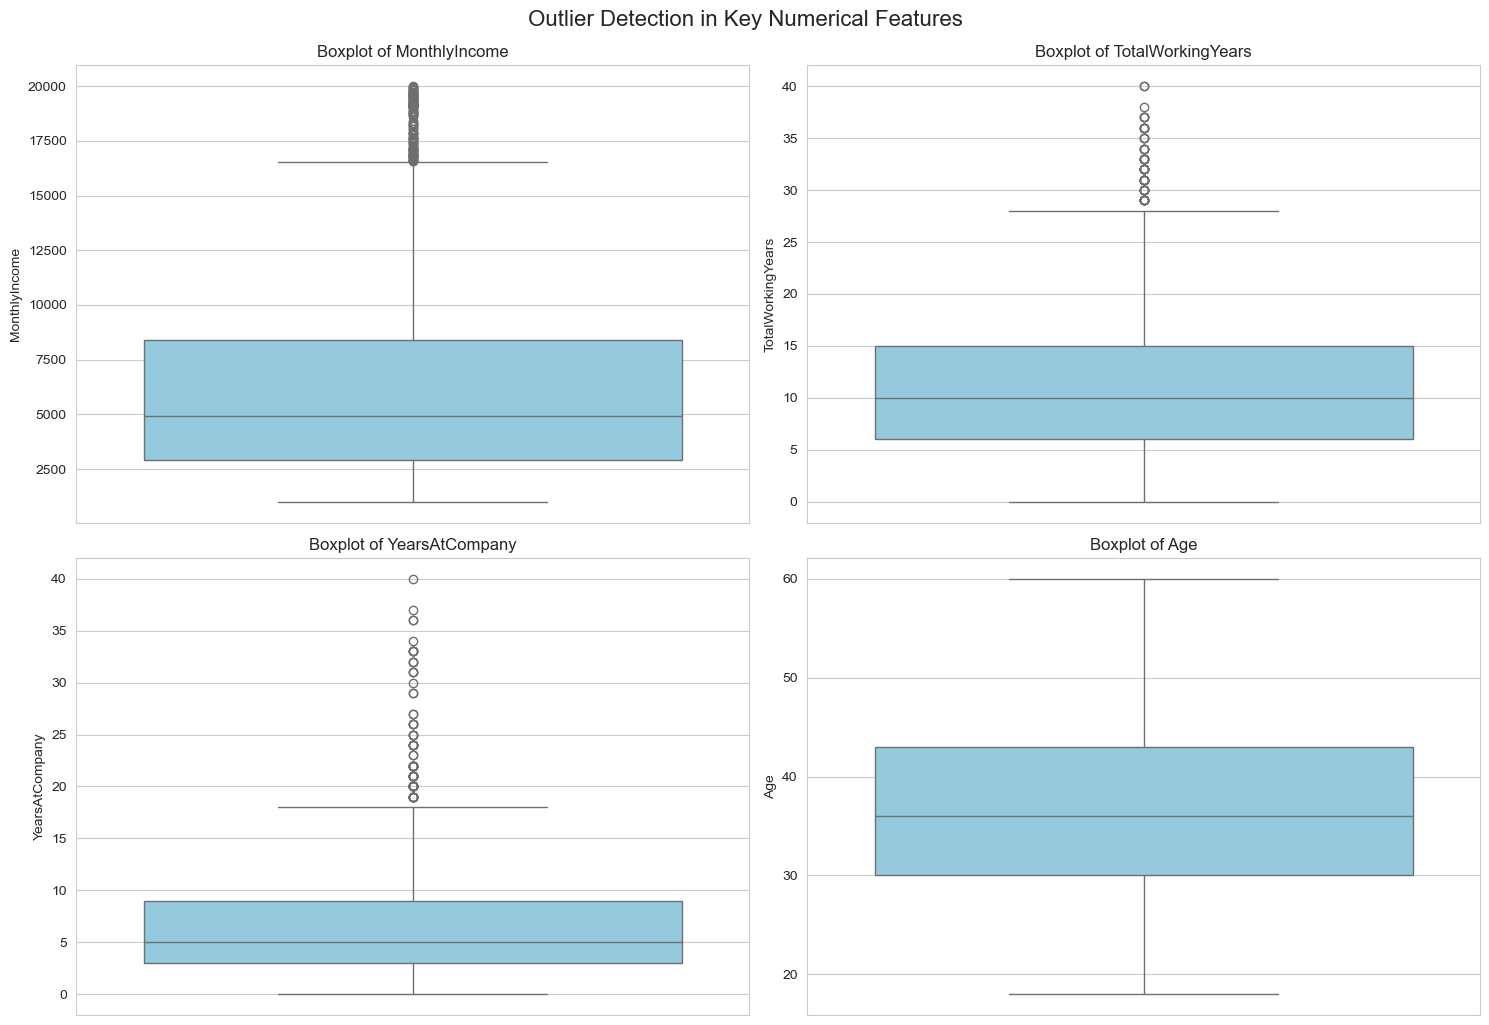


[INFO] Outlier Analysis:
Outliers are visible in 'MonthlyIncome', 'TotalWorkingYears', and 'YearsAtCompany'.
These are likely not errors but represent senior employees or high earners.
For this analysis, we will keep them as they contain valuable information, but in a real-world scenario, one might cap them or use robust scaling methods.

--- Exploratory Data Analysis (EDA) ---

[GRAPH 1] Attrition Distribution


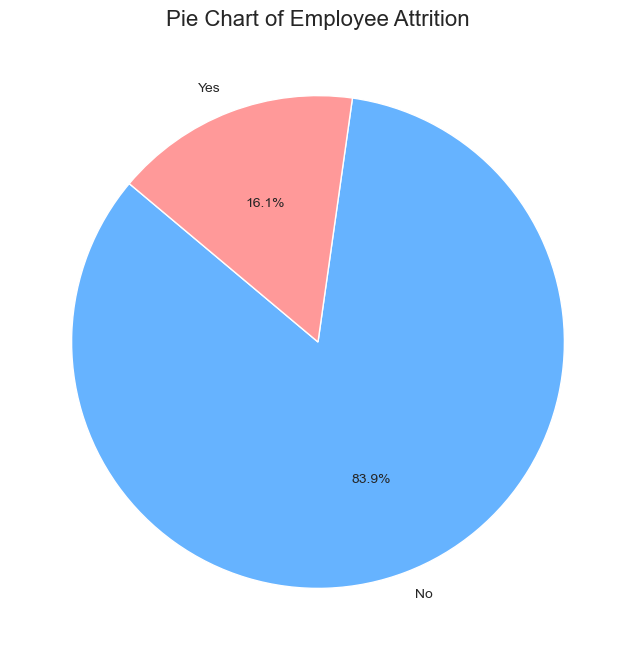

Insight: The dataset is imbalanced, with significantly more non-attrition cases.

[GRAPH 2] Attrition by Department


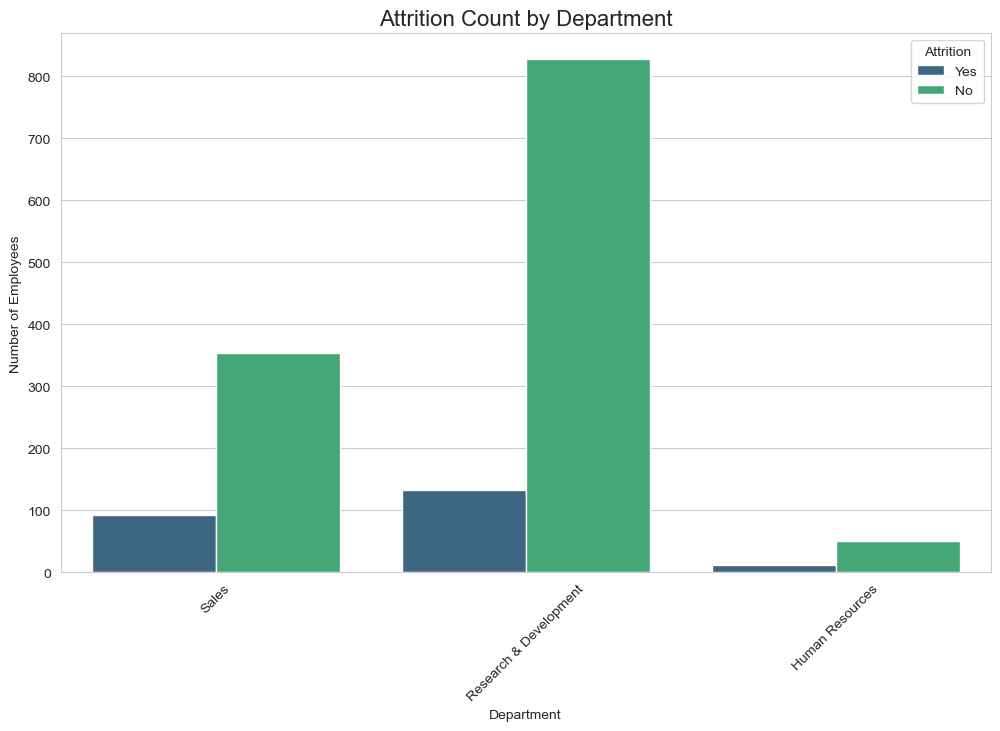

Insight: The Research & Development department has the highest number of employees and also the highest attrition count, but the proportion of attrition seems highest in Sales.

[GRAPH 3] Monthly Income vs. Attrition


C:\Users\lalit\AppData\Local\Temp\ipykernel_17704\2673980021.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Attrition', y='MonthlyIncome', data=df, palette='magma')


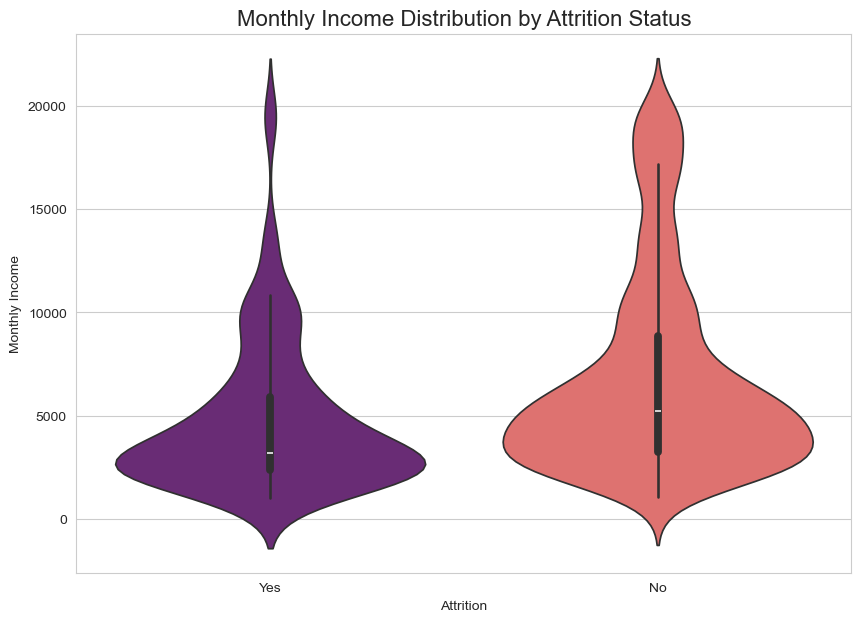

Insight: Employees with lower monthly incomes are more likely to leave the company.

[GRAPH 4] Job Role vs. Attrition


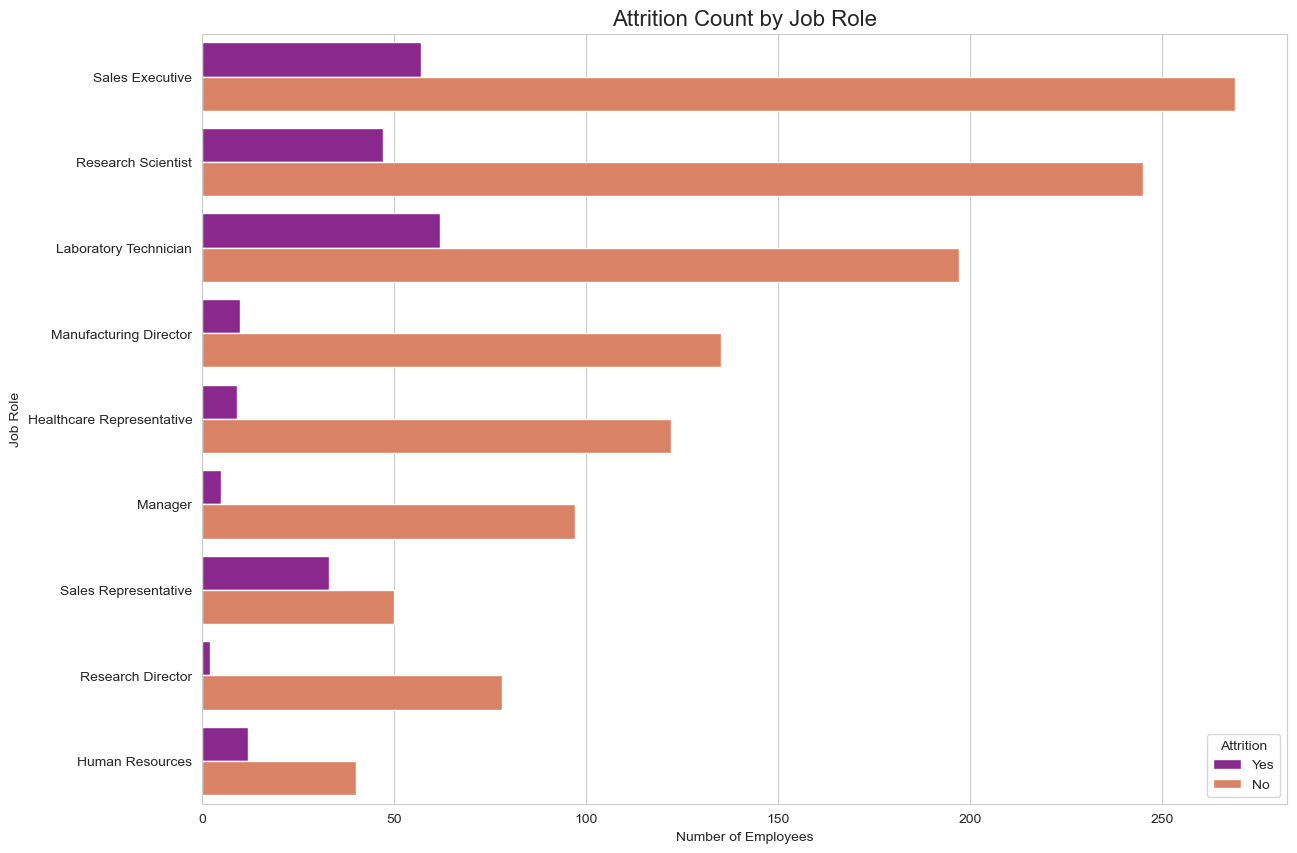

Insight: Laboratory Technicians, Sales Executives, and Research Scientists have the highest numbers of attrition.

[GRAPH 5] Age Distribution by Attrition


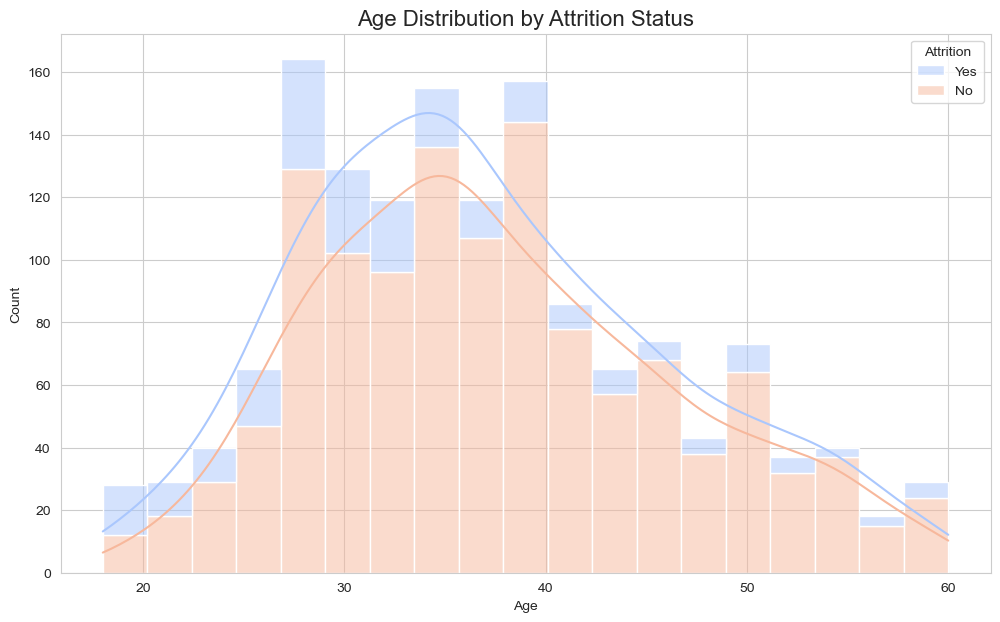

Insight: Attrition seems to be more common among younger employees, especially those in their late 20s and early 30s.

[GRAPH 6] Job Satisfaction vs. Attrition


C:\Users\lalit\AppData\Local\Temp\ipykernel_17704\2673980021.py:136: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Attrition', y='JobSatisfaction', data=df, palette='pastel')


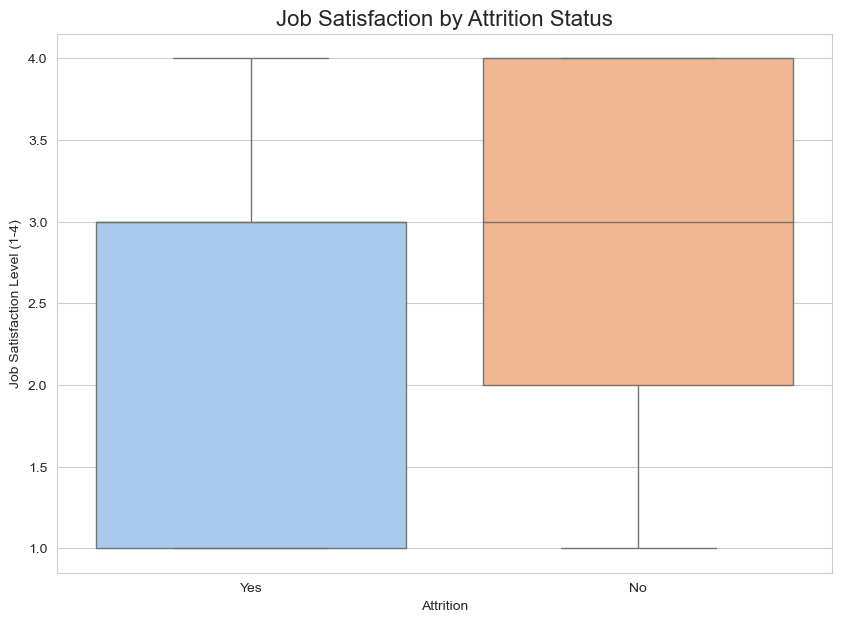

Insight: While there's an overlap, the median job satisfaction for employees who left is slightly lower. A wide range of satisfaction levels is seen in both groups.

[GRAPH 7] OverTime vs. Attrition


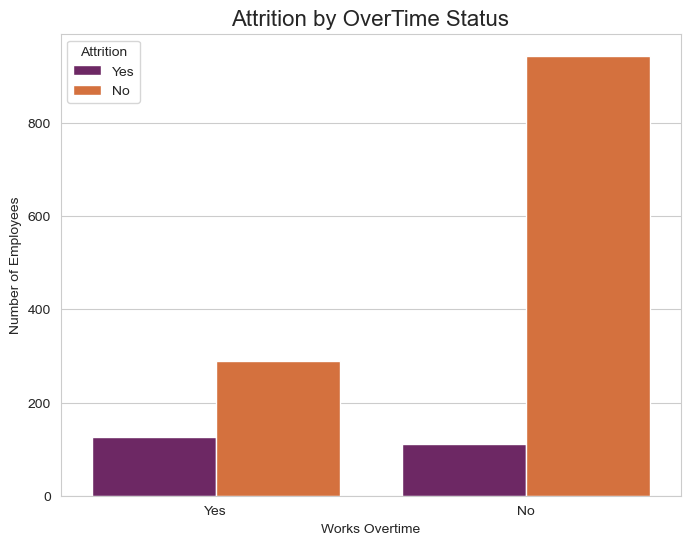

Insight: A significantly higher proportion of employees who work overtime end up leaving the company.

[GRAPH 8] Correlation Heatmap


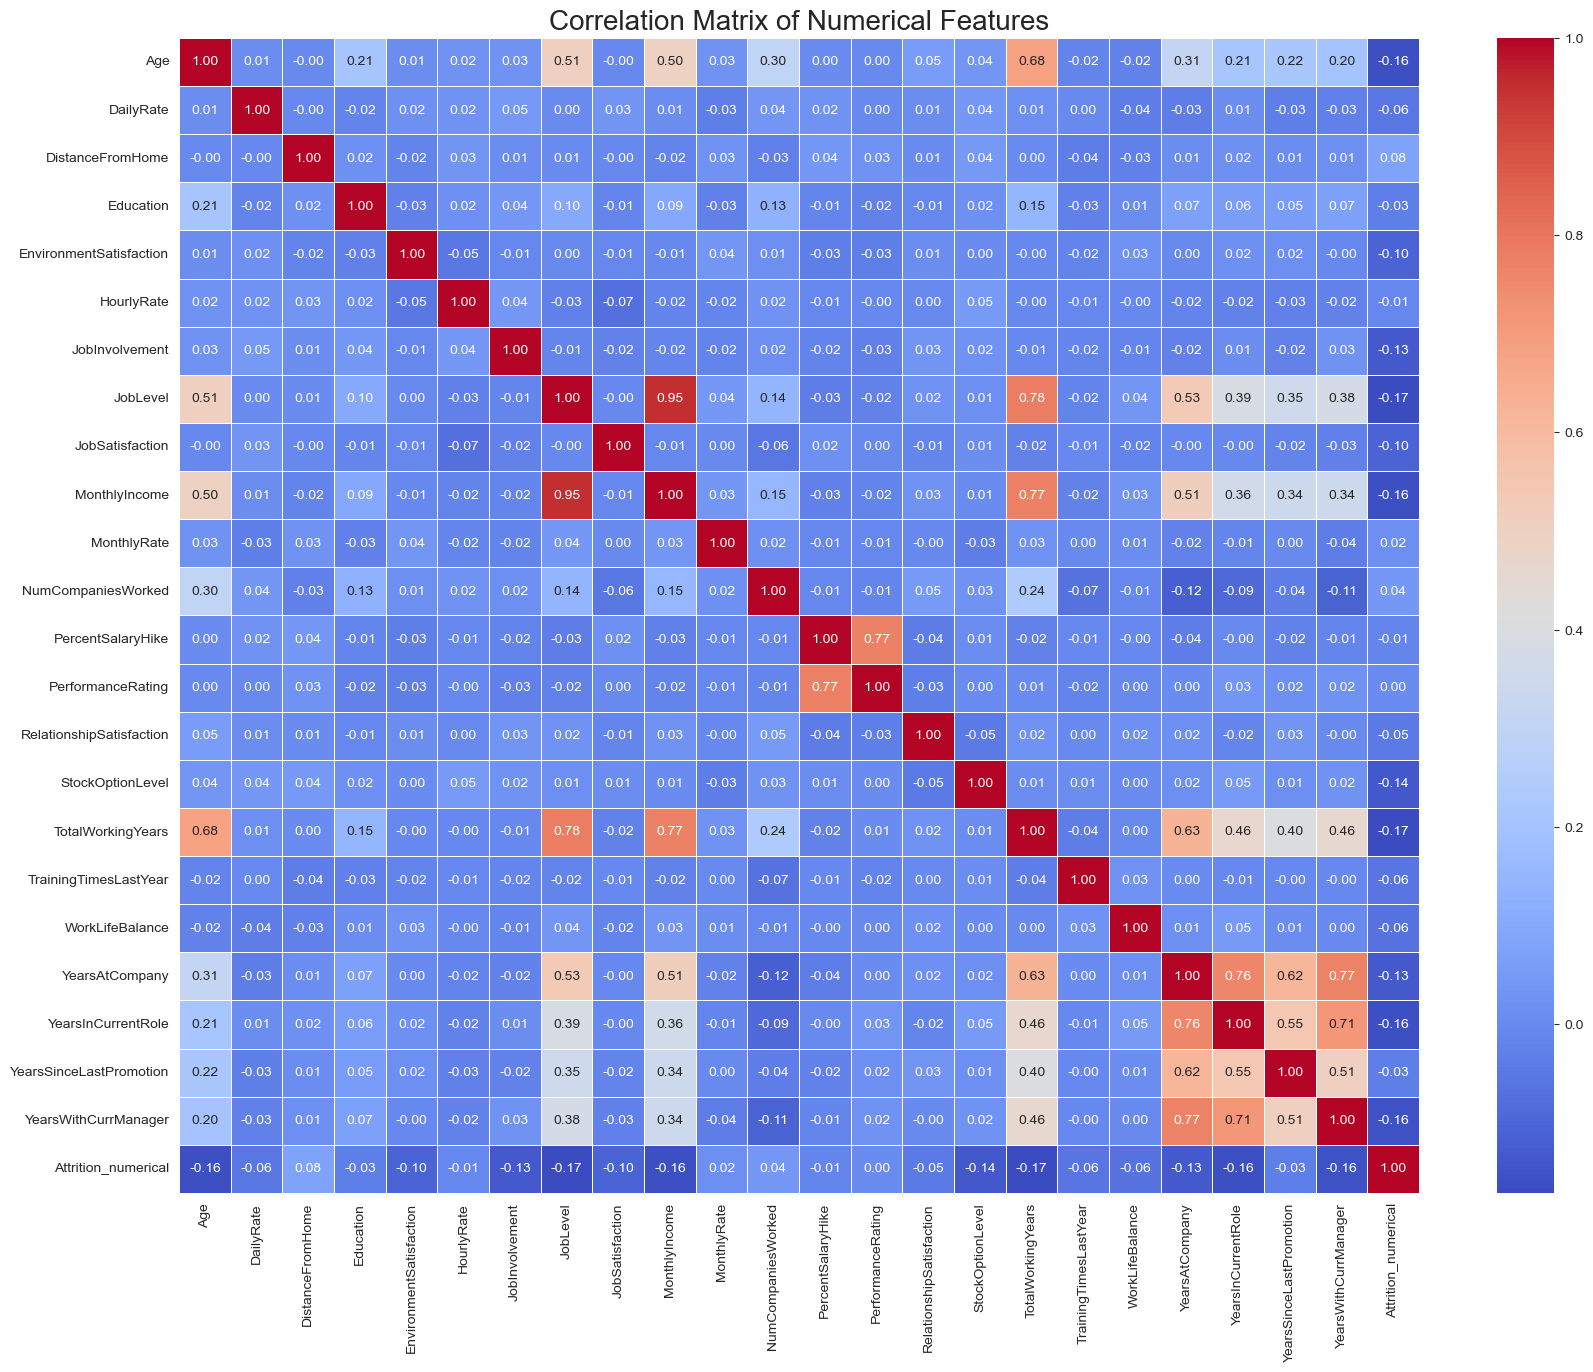

Insight: Strong positive correlations exist between 'MonthlyIncome' and 'TotalWorkingYears', and between 'YearsAtCompany', 'YearsWithCurrManager', and 'YearsInCurrentRole'. 'Attrition' has a negative correlation with most tenure- and satisfaction-related variables.

[GRAPH 9] Years At Company vs. Attrition


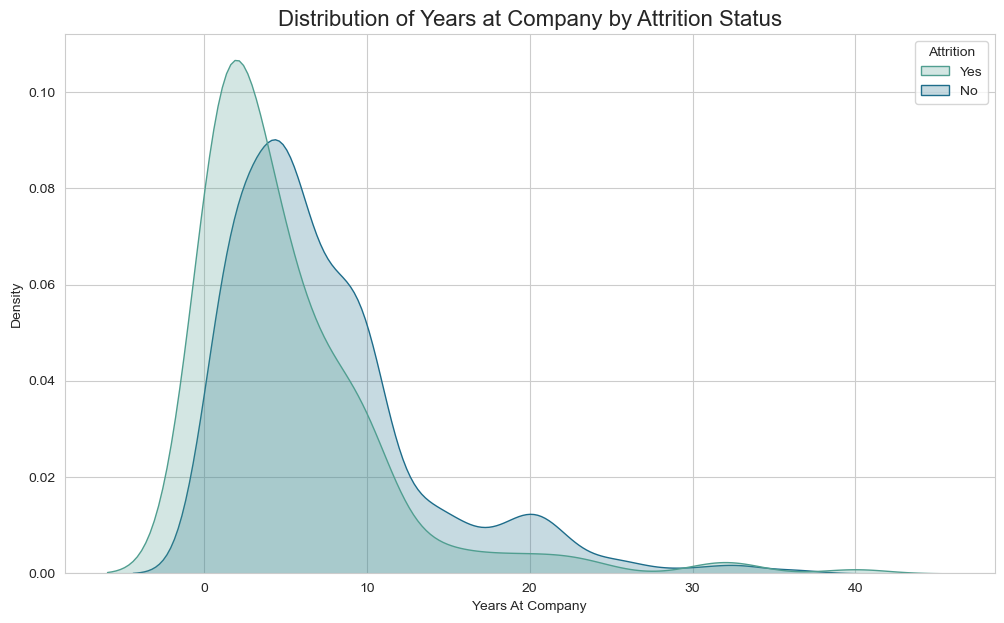

Insight: Attrition is highest among employees in their first few years at the company, especially in the very first year.

[GRAPH 10] Business Travel vs. Attrition


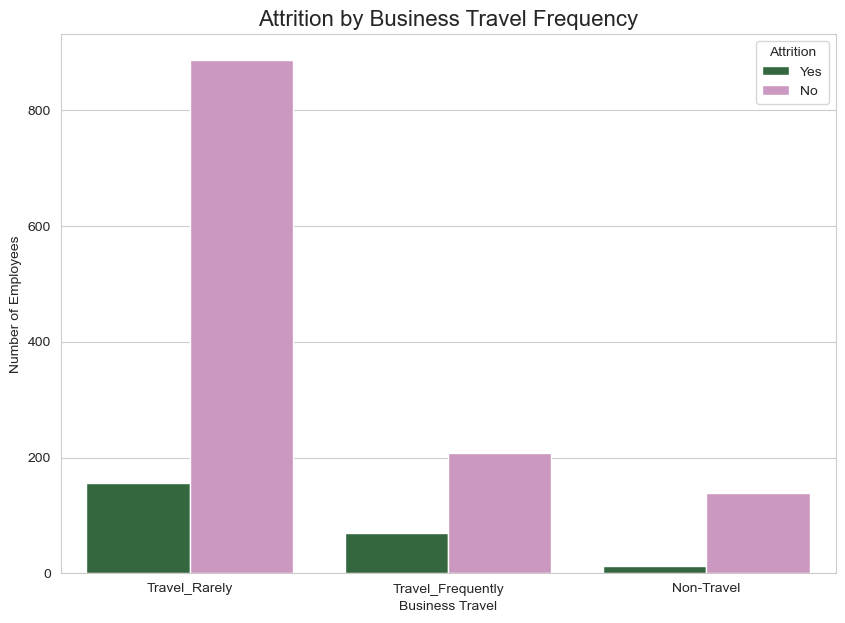

Insight: Employees who travel frequently have a higher proportion of attrition compared to those who travel rarely or not at all.

[GRAPH 11] Pairplot of Key Features


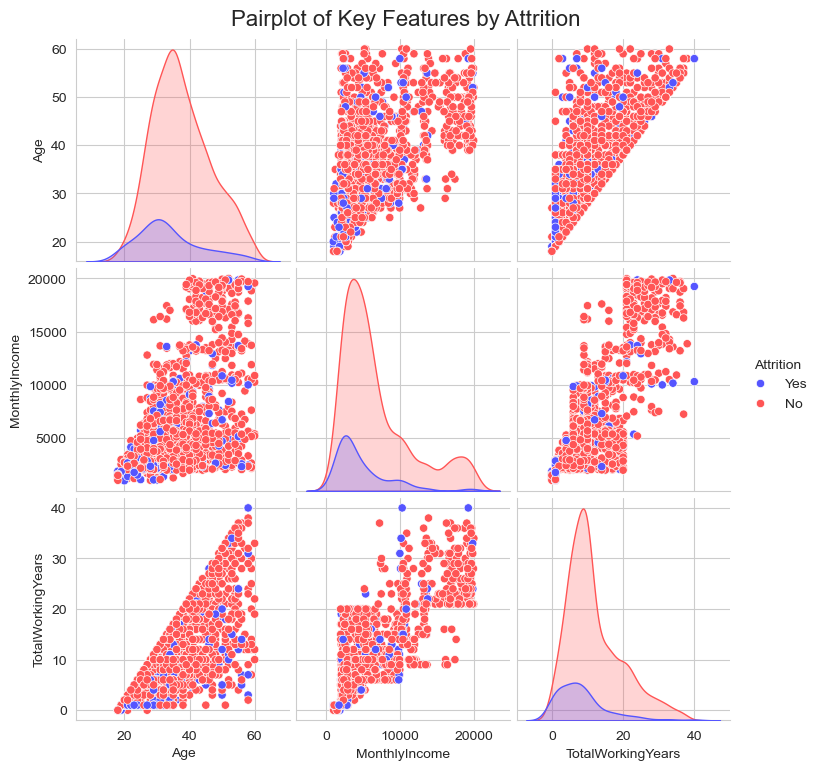

[I 2025-07-18 11:11:15,892] A new study created in memory with name: no-name-d9614555-16c4-4b73-a050-6108643b112a


Insight: This plot confirms relationships seen earlier, such as lower income and younger age being associated with attrition.

--- Data Preprocessing for ML ---

[INFO] Categorical features: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
[INFO] Numerical features: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

[INFO] Training set shape: X_train=(1176, 30), y_train=(1176,)
[INFO] Testing set shape: X_test=(294, 30), y_test=(294,)

--- Hyperparameter Tuning with Optuna ---

[INFO] Starting Optuna studies... This may take a few minutes.

--- Tun

[I 2025-07-18 11:11:37,303] Trial 1 finished with value: 0.8175172155836268 and parameters: {'n_estimators': 55, 'max_depth': 17, 'min_samples_split': 14, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8175172155836268.
[I 2025-07-18 11:11:37,513] Trial 4 finished with value: 0.8232641171263753 and parameters: {'n_estimators': 63, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 4 with value: 0.8232641171263753.
[I 2025-07-18 11:11:38,390] Trial 5 finished with value: 0.794282131188264 and parameters: {'n_estimators': 289, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 15}. Best is trial 4 with value: 0.8232641171263753.
[I 2025-07-18 11:11:40,204] Trial 3 finished with value: 0.8101525879934943 and parameters: {'n_estimators': 289, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 4 with value: 0.8232641171263753.
[I 2025-07-18 11:11:40,581] Trial 7 finished with value: 0.8077860384575184 and parameters: {

Best F1-score for RandomForest: 0.8283
Best hyperparameters: {'n_estimators': 496, 'max_depth': 13, 'min_samples_split': 12, 'min_samples_leaf': 2}

--- Tuning GradientBoosting ---


[I 2025-07-18 11:13:47,155] Trial 0 finished with value: 0.8479321872220151 and parameters: {'n_estimators': 255, 'learning_rate': 0.19670722840618302, 'max_depth': 3, 'subsample': 0.653849138292509}. Best is trial 0 with value: 0.8479321872220151.
[I 2025-07-18 11:13:51,634] Trial 1 finished with value: 0.8374334331721803 and parameters: {'n_estimators': 135, 'learning_rate': 0.1455471061007128, 'max_depth': 5, 'subsample': 0.9259991812856005}. Best is trial 0 with value: 0.8479321872220151.
[I 2025-07-18 11:14:13,680] Trial 2 finished with value: 0.8280532213537881 and parameters: {'n_estimators': 210, 'learning_rate': 0.10251372740245292, 'max_depth': 9, 'subsample': 0.6406184247167203}. Best is trial 0 with value: 0.8479321872220151.
[I 2025-07-18 11:14:14,999] Trial 3 finished with value: 0.8566163340198601 and parameters: {'n_estimators': 168, 'learning_rate': 0.22397448246447701, 'max_depth': 2, 'subsample': 0.7285451145444097}. Best is trial 3 with value: 0.8566163340198601.
[I

Best F1-score for GradientBoosting: 0.8593
Best hyperparameters: {'n_estimators': 439, 'learning_rate': 0.17893221563837006, 'max_depth': 3, 'subsample': 0.7457725369579153}

--- Tuning LogisticRegression ---


[I 2025-07-18 11:18:34,634] Trial 0 finished with value: 0.7647517071913613 and parameters: {'C': 0.00048274778109340264, 'solver': 'saga'}. Best is trial 0 with value: 0.7647517071913613.
[I 2025-07-18 11:18:34,943] Trial 7 finished with value: 0.7647517071913613 and parameters: {'C': 0.0017917907497156495, 'solver': 'liblinear'}. Best is trial 0 with value: 0.7647517071913613.
[I 2025-07-18 11:18:35,133] Trial 3 finished with value: 0.8702584784374972 and parameters: {'C': 19.377495797225013, 'solver': 'liblinear'}. Best is trial 3 with value: 0.8702584784374972.
[I 2025-07-18 11:18:35,303] Trial 4 finished with value: 0.8333151290830388 and parameters: {'C': 0.03252672645115243, 'solver': 'saga'}. Best is trial 3 with value: 0.8702584784374972.
[I 2025-07-18 11:18:35,458] Trial 2 finished with value: 0.8070960585802973 and parameters: {'C': 0.018009301612625372, 'solver': 'saga'}. Best is trial 3 with value: 0.8702584784374972.
[I 2025-07-18 11:18:35,788] Trial 5 finished with value

Best F1-score for LogisticRegression: 0.8718
Best hyperparameters: {'C': 0.8570299180727012, 'solver': 'liblinear'}

--- Optuna Results Summary ---
Models ranked by best F1-score:
1. LogisticRegression: F1-score = 0.8718
2. GradientBoosting: F1-score = 0.8593
3. RandomForest: F1-score = 0.8283

--- Model Training & Evaluation of Top 3 Models ---

--- Evaluating LogisticRegression ---
Accuracy: 0.8605
Precision: 0.6154
Recall: 0.3404
F1-Score: 0.4384

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       247
           1       0.62      0.34      0.44        47

    accuracy                           0.86       294
   macro avg       0.75      0.65      0.68       294
weighted avg       0.84      0.86      0.84       294



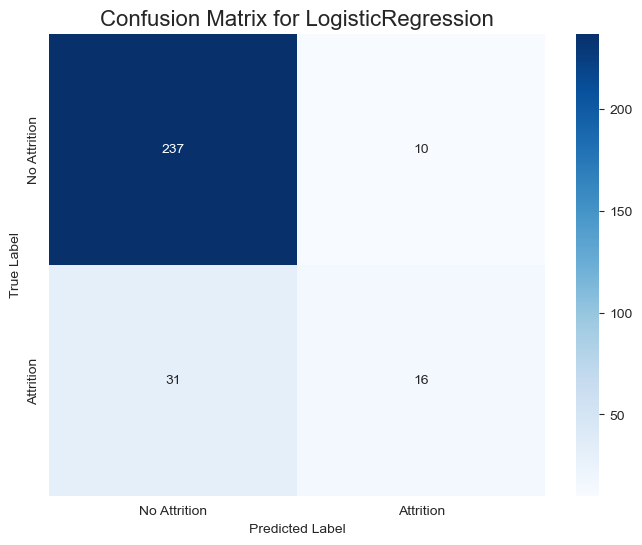

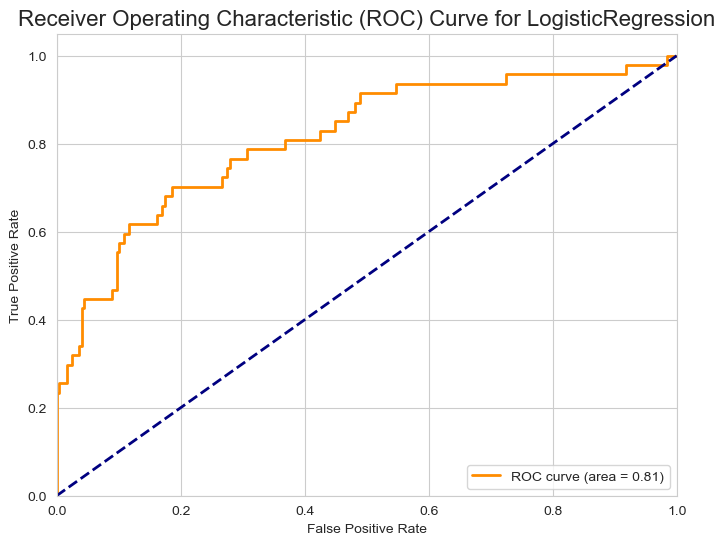


--- Evaluating GradientBoosting ---
Accuracy: 0.8401
Precision: 0.5000
Recall: 0.2553
F1-Score: 0.3380

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       247
           1       0.50      0.26      0.34        47

    accuracy                           0.84       294
   macro avg       0.69      0.60      0.62       294
weighted avg       0.81      0.84      0.82       294



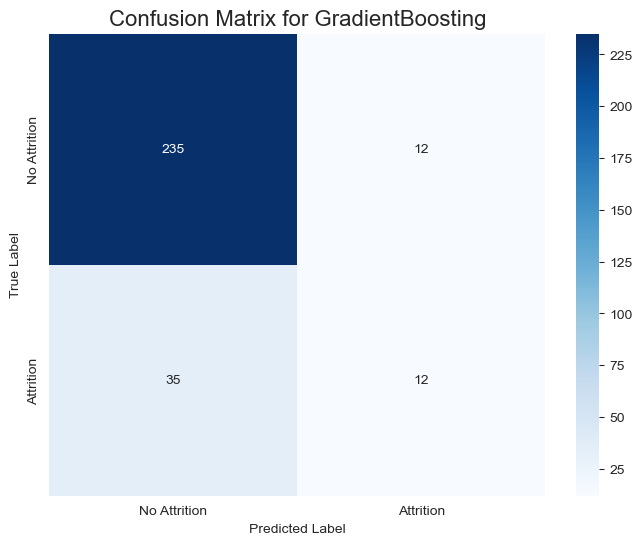

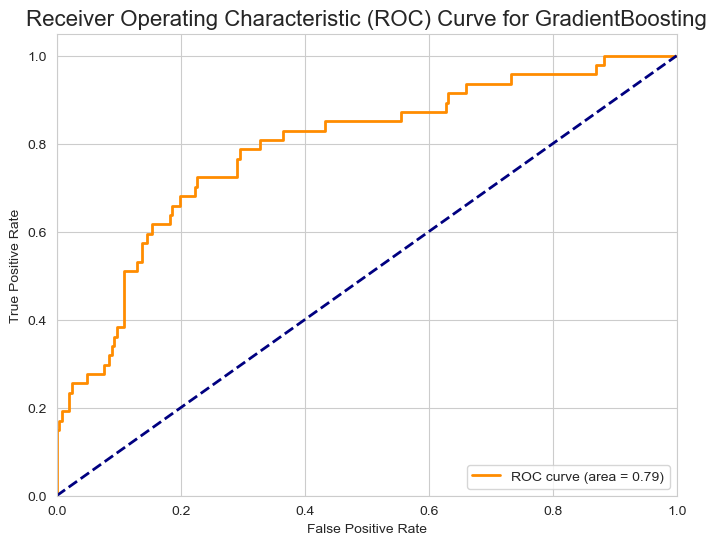


--- Evaluating RandomForest ---
Accuracy: 0.8367
Precision: 0.4444
Recall: 0.0851
F1-Score: 0.1429

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       247
           1       0.44      0.09      0.14        47

    accuracy                           0.84       294
   macro avg       0.65      0.53      0.53       294
weighted avg       0.78      0.84      0.79       294



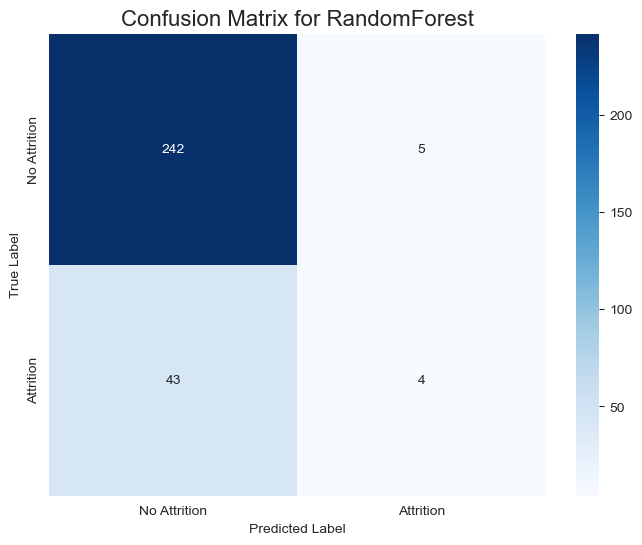

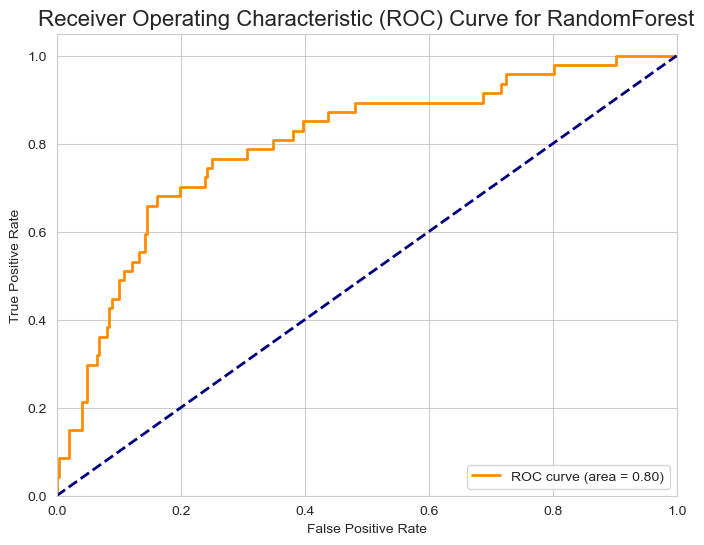


--- Saving the Best Model ---

[INFO] The best performing model is 'LogisticRegression'.
Saving the trained pipeline to 'best_hr_attrition_model.pkl'...

[SUCCESS] Model saved successfully.
You can now load 'best_hr_attrition_model.pkl' to make predictions on new data.

--- Example: Loading and Using the Saved Model ---

Sample Data:
      Age BusinessTravel  DailyRate Department  DistanceFromHome  Education  \
1061   24     Non-Travel        830      Sales                13          2   

     EducationField  EnvironmentSatisfaction  Gender  HourlyRate  ...  \
1061  Life Sciences                        4  Female          78  ...   

      PerformanceRating  RelationshipSatisfaction StockOptionLevel  \
1061                  3                         3                1   

      TotalWorkingYears TrainingTimesLastYear  WorkLifeBalance  \
1061                  1                     2                3   

      YearsAtCompany  YearsInCurrentRole YearsSinceLastPromotion  \
1061           

In [9]:

if not df.empty:
    # ## 2. Basic Data Analysis
    # Get a first look at the data's structure, content, and summary statistics.

    print("\n--- Basic Data Analysis ---")

    # Display the first 5 rows
    print("\n[INFO] First 5 rows of the dataset:")
    print(df.head())

    # Display the last 5 rows
    print("\n[INFO] Last 5 rows of the dataset:")
    print(df.tail())

    # Get the shape of the dataset (rows, columns)
    print(f"\n[INFO] Dataset Shape: {df.shape}")

    # Get the total number of elements
    print(f"\n[INFO] Dataset Size (Total Elements): {df.size}")

    # Get a concise summary of the dataframe
    print("\n[INFO] Dataset Information:")
    df.info()

    # Generate descriptive statistics for numerical columns
    print("\n[INFO] Descriptive Statistics (Numerical Columns):")
    print(df.describe())

    # Generate descriptive statistics for categorical columns
    print("\n[INFO] Descriptive Statistics (Categorical Columns):")
    print(df.describe(include=['object']))

    # Check value counts for the target variable 'Attrition'
    print("\n[INFO] Value Counts for 'Attrition':")
    print(df['Attrition'].value_counts())


    # ## 3. Data Cleaning
    # Check for missing values and outliers.

    print("\n--- Data Cleaning ---")

    # Check for any missing values in the dataset
    print("\n[INFO] Checking for Missing Values:")
    print(df.isnull().sum())
    print("\nResult: There are no missing values in this dataset.")

    # Drop columns that are constant or not useful for prediction
    # 'EmployeeCount', 'StandardHours', 'Over18' have single values for all rows.
    # 'EmployeeNumber' is just an identifier.
    print("\n[INFO] Dropping non-informative columns: 'EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber'")
    df.drop(['EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber'], axis=1, inplace=True)
    print(f"New dataset shape: {df.shape}")

    # Outlier Detection using Boxplots for key numerical features
    print("\n[INFO] Generating boxplots to detect outliers in key numerical features...")
    numerical_cols_for_outliers = ['MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany', 'Age']
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numerical_cols_for_outliers):
        plt.subplot(2, 2, i + 1)
        sns.boxplot(y=df[col], color='skyblue')
        plt.title(f'Boxplot of {col}')
        plt.ylabel(col)
    plt.tight_layout()
    plt.suptitle('Outlier Detection in Key Numerical Features', y=1.02, fontsize=16)
    plt.show()

    print("\n[INFO] Outlier Analysis:")
    print("Outliers are visible in 'MonthlyIncome', 'TotalWorkingYears', and 'YearsAtCompany'.")
    print("These are likely not errors but represent senior employees or high earners.")
    print("For this analysis, we will keep them as they contain valuable information, but in a real-world scenario, one might cap them or use robust scaling methods.")


    # ## 4. Exploratory Data Analysis (EDA)
    # Visualize the data to understand relationships and distributions.

    print("\n--- Exploratory Data Analysis (EDA) ---")

    # Convert Attrition to a numerical format for easier plotting (Yes=1, No=0)
    df['Attrition_numerical'] = df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

    # Graph 1: Attrition Distribution (Pie Chart)
    print("\n[GRAPH 1] Attrition Distribution")
    attrition_counts = df['Attrition'].value_counts()
    plt.figure(figsize=(8, 8))
    plt.pie(attrition_counts, labels=attrition_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#ff9999'])
    plt.title('Pie Chart of Employee Attrition', fontsize=16)
    plt.ylabel('')
    plt.show()
    print("Insight: The dataset is imbalanced, with significantly more non-attrition cases.")

    # Graph 2: Attrition by Department (Count Plot)
    print("\n[GRAPH 2] Attrition by Department")
    plt.figure(figsize=(12, 7))
    sns.countplot(x='Department', hue='Attrition', data=df, palette='viridis')
    plt.title('Attrition Count by Department', fontsize=16)
    plt.xlabel('Department')
    plt.ylabel('Number of Employees')
    plt.xticks(rotation=45)
    plt.show()
    print("Insight: The Research & Development department has the highest number of employees and also the highest attrition count, but the proportion of attrition seems highest in Sales.")

    # Graph 3: Monthly Income vs. Attrition (Violin Plot)
    print("\n[GRAPH 3] Monthly Income vs. Attrition")
    plt.figure(figsize=(10, 7))
    sns.violinplot(x='Attrition', y='MonthlyIncome', data=df, palette='magma')
    plt.title('Monthly Income Distribution by Attrition Status', fontsize=16)
    plt.xlabel('Attrition')
    plt.ylabel('Monthly Income')
    plt.show()
    print("Insight: Employees with lower monthly incomes are more likely to leave the company.")

    # Graph 4: Job Role vs. Attrition (Horizontal Bar Plot)
    print("\n[GRAPH 4] Job Role vs. Attrition")
    plt.figure(figsize=(14, 10))
    sns.countplot(y='JobRole', hue='Attrition', data=df, palette='plasma', order=df['JobRole'].value_counts().index)
    plt.title('Attrition Count by Job Role', fontsize=16)
    plt.xlabel('Number of Employees')
    plt.ylabel('Job Role')
    plt.show()
    print("Insight: Laboratory Technicians, Sales Executives, and Research Scientists have the highest numbers of attrition.")

    # Graph 5: Age Distribution of Employees (Histogram)
    print("\n[GRAPH 5] Age Distribution by Attrition")
    plt.figure(figsize=(12, 7))
    sns.histplot(data=df, x='Age', hue='Attrition', multiple='stack', kde=True, palette='coolwarm')
    plt.title('Age Distribution by Attrition Status', fontsize=16)
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.show()
    print("Insight: Attrition seems to be more common among younger employees, especially those in their late 20s and early 30s.")

    # Graph 6: Job Satisfaction vs. Attrition (Box Plot)
    print("\n[GRAPH 6] Job Satisfaction vs. Attrition")
    plt.figure(figsize=(10, 7))
    sns.boxplot(x='Attrition', y='JobSatisfaction', data=df, palette='pastel')
    plt.title('Job Satisfaction by Attrition Status', fontsize=16)
    plt.xlabel('Attrition')
    plt.ylabel('Job Satisfaction Level (1-4)')
    plt.show()
    print("Insight: While there's an overlap, the median job satisfaction for employees who left is slightly lower. A wide range of satisfaction levels is seen in both groups.")

    # Graph 7: OverTime vs. Attrition (Count Plot)
    print("\n[GRAPH 7] OverTime vs. Attrition")
    plt.figure(figsize=(8, 6))
    sns.countplot(x='OverTime', hue='Attrition', data=df, palette='inferno')
    plt.title('Attrition by OverTime Status', fontsize=16)
    plt.xlabel('Works Overtime')
    plt.ylabel('Number of Employees')
    plt.show()
    print("Insight: A significantly higher proportion of employees who work overtime end up leaving the company.")

    # Graph 8: Correlation Heatmap of Numerical Features
    print("\n[GRAPH 8] Correlation Heatmap")
    # Select only numerical columns for correlation matrix
    numerical_df = df.select_dtypes(include=np.number)
    plt.figure(figsize=(20, 15))
    correlation_matrix = numerical_df.corr()
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5)
    plt.title('Correlation Matrix of Numerical Features', fontsize=20)
    plt.show()
    print("Insight: Strong positive correlations exist between 'MonthlyIncome' and 'TotalWorkingYears', and between 'YearsAtCompany', 'YearsWithCurrManager', and 'YearsInCurrentRole'. 'Attrition' has a negative correlation with most tenure- and satisfaction-related variables.")

    # Graph 9: Years At Company vs. Attrition (KDE Plot)
    print("\n[GRAPH 9] Years At Company vs. Attrition")
    plt.figure(figsize=(12, 7))
    sns.kdeplot(data=df, x='YearsAtCompany', hue='Attrition', fill=True, common_norm=False, palette='crest')
    plt.title('Distribution of Years at Company by Attrition Status', fontsize=16)
    plt.xlabel('Years At Company')
    plt.ylabel('Density')
    plt.show()
    print("Insight: Attrition is highest among employees in their first few years at the company, especially in the very first year.")

    # Graph 10: Business Travel vs. Attrition (Bar Plot)
    print("\n[GRAPH 10] Business Travel vs. Attrition")
    plt.figure(figsize=(10, 7))
    sns.countplot(x='BusinessTravel', hue='Attrition', data=df, palette='cubehelix')
    plt.title('Attrition by Business Travel Frequency', fontsize=16)
    plt.xlabel('Business Travel')
    plt.ylabel('Number of Employees')
    plt.show()
    print("Insight: Employees who travel frequently have a higher proportion of attrition compared to those who travel rarely or not at all.")

    # Graph 11: Pairplot of Key Features
    print("\n[GRAPH 11] Pairplot of Key Features")
    pairplot_features = ['Age', 'MonthlyIncome', 'TotalWorkingYears', 'Attrition']
    sns.pairplot(df[pairplot_features], hue='Attrition', palette='seismic', diag_kind='kde')
    plt.suptitle('Pairplot of Key Features by Attrition', y=1.02, fontsize=16)
    plt.show()
    print("Insight: This plot confirms relationships seen earlier, such as lower income and younger age being associated with attrition.")


    # ## 5. Data Preprocessing for ML
    # Prepare the data by encoding categorical variables and splitting into train/test sets.

    print("\n--- Data Preprocessing for ML ---")

    # Drop the temporary numerical attrition column
    df_ml = df.drop('Attrition_numerical', axis=1)

    # Separate features (X) and target (y)
    X = df_ml.drop('Attrition', axis=1)
    y = df_ml['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0) # Encode target

    # Identify categorical and numerical features
    categorical_features = X.select_dtypes(include=['object']).columns
    numerical_features = X.select_dtypes(include=np.number).columns

    print(f"\n[INFO] Categorical features: {list(categorical_features)}")
    print(f"[INFO] Numerical features: {list(numerical_features)}")

    # Create preprocessing pipelines for numerical and categorical features
    # Numerical features will be scaled.
    # Categorical features will be one-hot encoded.
    numerical_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    # Create a preprocessor object using ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough' # Keep other columns (if any)
    )

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(f"\n[INFO] Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
    print(f"[INFO] Testing set shape: X_test={X_test.shape}, y_test={y_test.shape}")


    # ## 6. Hyperparameter Tuning with Optuna
    # Use Optuna to find the best models and their hyperparameters.
    # We will test Logistic Regression, Random Forest, and Gradient Boosting.

    print("\n--- Hyperparameter Tuning with Optuna ---")

    def objective(trial, model_name):
        # Define the hyperparameter search space for each model
        if model_name == 'LogisticRegression':
            C = trial.suggest_float('C', 1e-4, 1e2, log=True)
            solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
            model = LogisticRegression(C=C, solver=solver, random_state=42, max_iter=1000)
        elif model_name == 'RandomForest':
            n_estimators = trial.suggest_int('n_estimators', 50, 500)
            max_depth = trial.suggest_int('max_depth', 3, 20)
            min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
            min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)
            model = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                random_state=42
            )
        elif model_name == 'GradientBoosting':
            n_estimators = trial.suggest_int('n_estimators', 50, 500)
            learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
            max_depth = trial.suggest_int('max_depth', 2, 10)
            subsample = trial.suggest_float('subsample', 0.6, 1.0)
            model = GradientBoostingClassifier(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth,
                subsample=subsample,
                random_state=42
            )
        else:
            raise ValueError("Unsupported model name")

        # Create the full pipeline with preprocessor and model
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('classifier', model)])

        # Evaluate the model using cross-validation on the training data
        # We use F1-score as the metric because the dataset is imbalanced.
        score = cross_val_score(pipeline, X_train, y_train, n_jobs=-1, cv=5, scoring='f1_weighted').mean()
        return score

    # --- Run Optuna Studies ---
    models_to_tune = ['RandomForest', 'GradientBoosting', 'LogisticRegression']
    studies = {}

    print("\n[INFO] Starting Optuna studies... This may take a few minutes.")
    for model_name in models_to_tune:
        print(f"\n--- Tuning {model_name} ---")
        study = optuna.create_study(direction='maximize')
        study.optimize(lambda trial: objective(trial, model_name), n_trials=50, n_jobs=-1)
        studies[model_name] = study
        print(f"Best F1-score for {model_name}: {study.best_value:.4f}")
        print(f"Best hyperparameters: {study.best_params}")

    # --- Find Top 3 Models ---
    best_models = sorted(studies.items(), key=lambda item: item[1].best_value, reverse=True)
    print("\n--- Optuna Results Summary ---")
    print("Models ranked by best F1-score:")
    for i, (model_name, study) in enumerate(best_models):
        print(f"{i+1}. {model_name}: F1-score = {study.best_value:.4f}")

    top_3_models = best_models[:3]


    # ## 7. Model Training & Evaluation
    # Train the top 3 models using the best hyperparameters and evaluate their performance on the test set.

    print("\n--- Model Training & Evaluation of Top 3 Models ---")

    trained_pipelines = {}

    for model_name, study in top_3_models:
        print(f"\n--- Evaluating {model_name} ---")

        # Get the best hyperparameters
        best_params = study.best_params

        # Create the model instance with the best params
        if model_name == 'LogisticRegression':
            model = LogisticRegression(**best_params, random_state=42, max_iter=1000)
        elif model_name == 'RandomForest':
            model = RandomForestClassifier(**best_params, random_state=42)
        elif model_name == 'GradientBoosting':
            model = GradientBoostingClassifier(**best_params, random_state=42)

        # Create and train the pipeline
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('classifier', model)])
        pipeline.fit(X_train, y_train)
        trained_pipelines[model_name] = pipeline

        # Make predictions on the test set
        y_pred = pipeline.predict(X_test)
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

        # --- Evaluation Metrics ---
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"Precision: {precision_score(y_test, y_pred):.4f}")
        print(f"Recall: {recall_score(y_test, y_pred):.4f}")
        print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

        # Classification Report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['No Attrition', 'Attrition'],
                    yticklabels=['No Attrition', 'Attrition'])
        plt.title(f'Confusion Matrix for {model_name}', fontsize=16)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

        # ROC Curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic (ROC) Curve for {model_name}', fontsize=16)
        plt.legend(loc="lower right")
        plt.show()


    # ## 8. Save Final Model
    # Select the best performing model based on test set evaluation and save it as a .pkl file.
    # We'll choose the model with the highest F1-score on the test set.

    print("\n--- Saving the Best Model ---")

    best_model_name = top_3_models[0][0] # The model with the highest CV score from Optuna
    best_pipeline = trained_pipelines[best_model_name]

    print(f"\n[INFO] The best performing model is '{best_model_name}'.")
    print("Saving the trained pipeline to 'best_hr_attrition_model.pkl'...")

    # Save the entire pipeline (preprocessor + model) to a file
    with open('best_hr_attrition_model.pkl', 'wb') as f:
        pickle.dump(best_pipeline, f)

    print("\n[SUCCESS] Model saved successfully.")
    print("You can now load 'best_hr_attrition_model.pkl' to make predictions on new data.")

    # Example of loading and using the model
    print("\n--- Example: Loading and Using the Saved Model ---")
    with open('best_hr_attrition_model.pkl', 'rb') as f:
        loaded_pipeline = pickle.load(f)

    # Use a single sample from the test set for prediction
    sample_data = X_test.iloc[[0]]
    prediction = loaded_pipeline.predict(sample_data)[0]
    prediction_proba = loaded_pipeline.predict_proba(sample_data)[0]

    print(f"\nSample Data:\n{sample_data}")
    print(f"\nPredicted Attrition (0=No, 1=Yes): {prediction}")
    print(f"Prediction Probability (No, Yes): {prediction_proba}")

    print("\n\n--- End of Project ---")

else:
    print("\nExecution stopped because the dataset could not be loaded.")